# Trainable Wavelet-based CT–MRI Fusion (No Ground Truth)
**Option 1: Keep DWT fusion method, learn the fusion weights via backprop.**

This notebook provides an end-to-end pipeline:
- Dataset loader for paired, registered CT & MRI images
- Trainable wavelet fusion model with **learnable per-band weights**
- Unsupervised losses (SSIM + Gradient + Perceptual) for training without GT
- Training/validation loops, checkpointing, and quick visualization
- Simple inference helpers to fuse new pairs or a whole folder

> Assumptions: Inputs are **grayscale** and **spatially registered**.

---

## 0) Install dependencies (if needed)
- `pytorch_wavelets` provides differentiable DWT/IDWT in PyTorch.
- `opencv-python` for I/O and simple preprocessing.

In [1]:
# !pip install pytorch_wavelets opencv-python Pillow matplotlib
# # If you don't already have torch/torchvision:
# # !pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

## 1) Imports & Utilities

In [2]:
import os
import glob
from typing import Tuple, List

import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from torchvision import models

# Differentiable wavelets
from pytorch_wavelets import DWTForward, DWTInverse

# Reproducibility
def seed_all(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_all(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 2) Dataset: Paired CT & MRI
Folder structure:
```
data/
  ct/  image001.png, image002.png, ...
  mri/ image001.png, image002.png, ...  # same file names
```

In [3]:
class PairedMedicalFusionDataset(Dataset):
    """Paired dataset for registered CT & MRI images.
    - root_ct, root_mri: directories with identical filenames
    - resize: (H,W) or None
    - file_exts: accepted extensions
    """
    def __init__(self, root_ct: str, root_mri: str, resize: Tuple[int,int]=None,
                 file_exts=(".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
        self.root_ct = root_ct
        self.root_mri = root_mri
        self.resize = resize

        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\','/'): p for p in paths}
            return base

        base_ct = index_dir(root_ct)
        base_mr = index_dir(root_mri)
        self.keys = sorted(list(set(base_ct.keys()) & set(base_mr.keys())))
        if not self.keys:
            raise RuntimeError("No paired files found. Ensure matching filenames between CT and MRI.")
        self.base_ct = base_ct
        self.base_mr = base_mr

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx: int):
        key = self.keys[idx]
        p_ct = self.base_ct[key]
        p_mr = self.base_mr[key]

        ct = cv2.imread(p_ct, cv2.IMREAD_GRAYSCALE)
        mr = cv2.imread(p_mr, cv2.IMREAD_GRAYSCALE)
        if ct is None or mr is None:
            raise FileNotFoundError(p_ct if ct is None else p_mr)
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mr = cv2.resize(mr, (W, H), interpolation=cv2.INTER_AREA)

        ct = ct.astype(np.float32)
        mr = mr.astype(np.float32)
        if ct.max() > 1.0: ct /= 255.0
        if mr.max() > 1.0: mr /= 255.0

        ct_t = torch.from_numpy(ct)[None, ...]   # (1,H,W)
        mr_t = torch.from_numpy(mr)[None, ...]
        return ct_t, mr_t, key

## 3) Losses (Unsupervised)
- **SSIM loss**: encourages structural similarity with each source
- **Gradient loss**: encourages edge/detail preservation
- **Perceptual (VGG19) loss**: keeps high-level texture/structure

In [4]:
class SSIM(nn.Module):
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1 = C1
        self.C2 = C2
        gauss = cv2.getGaussianKernel(window_size, window_size/6)
        gauss = gauss @ gauss.T
        w = torch.from_numpy(gauss.astype(np.float32))[None, None]
        self.register_buffer('window', w)

    def _filt(self, x):
        pad = self.window_size//2
        window = self.window.to(x.device)
        return F.conv2d(x, window, padding=pad, groups=x.size(1))

    def forward(self, x, y):
        # x,y: (B,1,H,W) in [0,1]
        mu_x = self._filt(x)
        mu_y = self._filt(y)
        mu_x2, mu_y2, mu_xy = mu_x*mu_x, mu_y*mu_y, mu_x*mu_y
        sigma_x2 = self._filt(x*x) - mu_x2
        sigma_y2 = self._filt(y*y) - mu_y2
        sigma_xy = self._filt(x*y) - mu_xy
        ssim = ((2*mu_xy + self.C1)*(2*sigma_xy + self.C2)) / ((mu_x2 + mu_y2 + self.C1)*(sigma_x2 + sigma_y2 + self.C2) + 1e-8)
        return ssim.mean()

def ssim_loss(fused, src):
    return 1.0 - SSIM()(fused, src)

In [5]:
class GradientLoss(nn.Module):
    def __init__(self):
        super().__init__()
        kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=np.float32)
        ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=np.float32)
        self.register_buffer('kx', torch.from_numpy(kx)[None, None])
        self.register_buffer('ky', torch.from_numpy(ky)[None, None])

    def forward(self, fused, ct, mr):
        def grad(img):
            gx = F.conv2d(img, self.kx, padding=1)
            gy = F.conv2d(img, self.ky, padding=1)
            return torch.sqrt(gx*gx + gy*gy + 1e-8)
        gF = grad(fused)
        gC = grad(ct)
        gM = grad(mr)
        gT = torch.max(gC, gM)
        return F.l1_loss(gF, gT)

In [6]:
class VGGPerceptual(nn.Module):
    def __init__(self, device):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features
        self.slice1 = nn.Sequential(*[vgg[i] for i in range(4)])   # relu1_2
        self.slice2 = nn.Sequential(*[vgg[i] for i in range(4,9)]) # relu2_2
        for p in self.parameters():
            p.requires_grad = False
        self.to(device)

    def forward(self, x):
        # grayscale -> 3ch + ImageNet norm
        x3 = x.repeat(1,3,1,1)
        mean = torch.tensor([0.485, 0.456, 0.406], device=x.device)[None,:,None,None]
        std  = torch.tensor([0.229, 0.224, 0.225], device=x.device)[None,:,None,None]
        x3 = (x3 - mean) / std
        f1 = self.slice1(x3)
        f2 = self.slice2(f1)
        return f1, f2

def perceptual_loss(vgg: VGGPerceptual, fused, ct, mr):
    fF1, fF2 = vgg(fused)
    cF1, cF2 = vgg(ct)
    mF1, mF2 = vgg(mr)
    return 0.5*(F.l1_loss(fF1, cF1) + F.l1_loss(fF1, mF1) + F.l1_loss(fF2, cF2) + F.l1_loss(fF2, mF2))

In [7]:
class FusionLoss(nn.Module):
    def __init__(self, device, w_ssim=1.0, w_grad=1.0, w_perc=0.1):
        super().__init__()
        self.ssim = SSIM()
        self.grad = GradientLoss()
        self.vgg = VGGPerceptual(device)
        self.w_ssim = w_ssim
        self.w_grad = w_grad
        self.w_perc = w_perc
        
    def forward(self, fused, ct, mr):
        l_ssim = 0.5*(1.0 - self.ssim(fused, ct)) + 0.5*(1.0 - self.ssim(fused, mr))
        l_grad = self.grad(fused, ct, mr)
        l_perc = perceptual_loss(self.vgg, fused, ct, mr)
        total = self.w_ssim*l_ssim + self.w_grad*l_grad + self.w_perc*l_perc
        return total, {"ssim": l_ssim.item(), "grad": l_grad.item(), "perc": l_perc.item()}

## 4) Trainable Wavelet Fusion Model (Option 1)
Keep DWT framework, make per-band fusion weights **learnable** in [0,1] via `sigmoid`.

In [8]:
class WaveletFusionNet(nn.Module):
    def __init__(self, wave: str = 'haar'):
        super().__init__()
        self.dwt = DWTForward(J=1, wave=wave)   # one-level DWT
        self.idwt = DWTInverse(wave=wave)
        # Unconstrained parameters; pass through sigmoid -> (0,1)
        self._a_low = nn.Parameter(torch.tensor(0.0))  # sigmoid(0)=0.5
        self._a_lh  = nn.Parameter(torch.tensor(0.0))
        self._a_hl  = nn.Parameter(torch.tensor(0.0))
        self._a_hh  = nn.Parameter(torch.tensor(0.0))

    @property
    def alpha_low(self): return torch.sigmoid(self._a_low)
    @property
    def alpha_lh(self):  return torch.sigmoid(self._a_lh)
    @property
    def alpha_hl(self):  return torch.sigmoid(self._a_hl)
    @property
    def alpha_hh(self):  return torch.sigmoid(self._a_hh)

    def forward(self, ct, mr):
        # Inputs: (B,1,H,W) in [0,1]
        ct_low, ct_high = self.dwt(ct)
        mr_low, mr_high = self.dwt(mr)
        # ct_high[0]: (B, 3, H/2, W/2) order = (LH, HL, HH)
        ct_lh, ct_hl, ct_hh = ct_high[0][:,0:1], ct_high[0][:,1:2], ct_high[0][:,2:3]
        mr_lh, mr_hl, mr_hh = mr_high[0][:,0:1], mr_high[0][:,1:2], mr_high[0][:,2:3]

        # Weighted fusion for each band
        aL  = self.alpha_low
        aLH = self.alpha_lh
        aHL = self.alpha_hl
        aHH = self.alpha_hh

        fused_low = aL*ct_low + (1.0 - aL)*mr_low
        fused_lh  = aLH*ct_lh + (1.0 - aLH)*mr_lh
        fused_hl  = aHL*ct_hl + (1.0 - aHL)*mr_hl
        fused_hh  = aHH*ct_hh + (1.0 - aHH)*mr_hh

        fused_high = torch.cat([fused_lh, fused_hl, fused_hh], dim=1)  # (B,3,h,w)
        fused = self.idwt((fused_low, [fused_high]))
        return fused

## 5) Training & Validation

In [9]:
from dataclasses import dataclass

@dataclass
class Config:
    ct_dir: str = 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT'
    mri_dir: str = 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI'
    save_dir: str = 'checkpoints_wavelet'
    resize: Tuple[int,int] = None  # e.g., (256,256)
    batch_size: int = 8
    epochs: int = 100
    lr: float = 1e-3
    val_split: float = 0.1
    wave: str = 'haar'
    w_ssim: float = 1.0
    w_grad: float = 1.0
    w_perc: float = 0.1

cfg = Config()
print(cfg)

Config(ct_dir='Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT', mri_dir='Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI', save_dir='checkpoints_wavelet', resize=None, batch_size=8, epochs=100, lr=0.001, val_split=0.1, wave='haar', w_ssim=1.0, w_grad=1.0, w_perc=0.1)


In [10]:
# Build dataset & loaders
os.makedirs(cfg.save_dir, exist_ok=True)

dset = PairedMedicalFusionDataset(cfg.ct_dir, cfg.mri_dir, resize=cfg.resize)
N = len(dset)
N_val = max(1, int(N * cfg.val_split))
N_tr  = N - N_val
train_set, val_set = torch.utils.data.random_split(dset, [N_tr, N_val])

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set,   batch_size=cfg.batch_size, shuffle=False, num_workers=0)
print(f"Train: {len(train_set)} | Val: {len(val_set)}")

Train: 144 | Val: 16


In [11]:
# Init model & loss
model = WaveletFusionNet(wave=cfg.wave).to(device)
loss_fn = FusionLoss(device, w_ssim=cfg.w_ssim, w_grad=cfg.w_grad, w_perc=cfg.w_perc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

best_val = float('inf')

/mnt/Work/conda/installation/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/Work/conda/installation/envs/ml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Training loop
epoch_metrics = []
best_epoch = 0

for epoch in range(1, cfg.epochs+1):
    model.train()
    tr_running = 0.0
    for ct, mr, _ in train_loader:
        ct = ct.to(device)
        mr = mr.to(device)
        fused = model(ct, mr)
        loss, parts = loss_fn(fused, ct, mr)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_running += loss.item() * ct.size(0)
    tr_loss = tr_running / len(train_set)

    # Validation
    model.eval()
    va_running = 0.0
    with torch.no_grad():
        for ct, mr, _ in val_loader:
            ct = ct.to(device)
            mr = mr.to(device)
            fused = model(ct, mr)
            loss, parts = loss_fn(fused, ct, mr)
            va_running += loss.item() * ct.size(0)
    va_loss = va_running / len(val_set)

    # Store epoch metrics
    epoch_metrics.append({
        'epoch': epoch,
        'train_loss': tr_loss,
        'val_loss': va_loss,
        'alpha_low': model.alpha_low.item(),
        'alpha_lh': model.alpha_lh.item(),
        'alpha_hl': model.alpha_hl.item(),
        'alpha_hh': model.alpha_hh.item()
    })

    print(f"Epoch {epoch:03d} | train {tr_loss:.4f} | val {va_loss:.4f} | alphas: L={model.alpha_low.item():.3f}, LH={model.alpha_lh.item():.3f}, HL={model.alpha_hl.item():.3f}, HH={model.alpha_hh.item():.3f}")

    # Save best model with comprehensive information
    if va_loss < best_val:
        best_val = va_loss
        best_epoch = epoch
        ckpt_path = os.path.join(cfg.save_dir, 'wavelet_fusion_best.pt')
        
        # Create comprehensive checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'best_val_loss': best_val,
            'train_loss': tr_loss,
            'epoch_metrics': epoch_metrics,
            'model_config': {
                'model_type': 'WaveletFusionNet',
                'wave': cfg.wave,
                'learned_alphas': {
                    'alpha_low': model.alpha_low.item(),
                    'alpha_lh': model.alpha_lh.item(),
                    'alpha_hl': model.alpha_hl.item(),
                    'alpha_hh': model.alpha_hh.item()
                }
            },
            'cfg': cfg.__dict__
        }
        
        torch.save(checkpoint, ckpt_path)
        print(f'✅ New best model saved: {ckpt_path} (Val Loss: {best_val:.4f})')

    # Save checkpoint every 10 epochs
    if epoch % 10 == 0:
        ckpt_path = os.path.join(cfg.save_dir, f'wavelet_fusion_epoch_{epoch}.pt')
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'val_loss': va_loss,
            'train_loss': tr_loss,
            'epoch_metrics': epoch_metrics,
            'model_config': {
                'model_type': 'WaveletFusionNet',
                'wave': cfg.wave,
                'learned_alphas': {
                    'alpha_low': model.alpha_low.item(),
                    'alpha_lh': model.alpha_lh.item(),
                    'alpha_hl': model.alpha_hl.item(),
                    'alpha_hh': model.alpha_hh.item()
                }
            },
            'cfg': cfg.__dict__
        }
        torch.save(checkpoint, ckpt_path)
        print(f'💾 Checkpoint saved: wavelet_fusion_epoch_{epoch}.pt')

print(f"\n{'='*70}")
print("Training Complete!")
print(f"Best model achieved at epoch {best_epoch} with validation loss: {best_val:.4f}")
print(f"Final learned fusion weights:")
print(f"  Low-frequency (α_L):  {model.alpha_low.item():.4f}")
print(f"  LH detail (α_LH):     {model.alpha_lh.item():.4f}")
print(f"  HL detail (α_HL):     {model.alpha_hl.item():.4f}")
print(f"  HH detail (α_HH):     {model.alpha_hh.item():.4f}")
print(f"Best model saved to: {os.path.join(cfg.save_dir, 'wavelet_fusion_best.pt')}")

# Save training history
training_history = {
    'epoch_metrics': epoch_metrics,
    'best_epoch': best_epoch,
    'best_val_loss': best_val,
    'final_alphas': {
        'alpha_low': model.alpha_low.item(),
        'alpha_lh': model.alpha_lh.item(),
        'alpha_hl': model.alpha_hl.item(),
        'alpha_hh': model.alpha_hh.item()
    }
}
torch.save(training_history, os.path.join(cfg.save_dir, 'training_history.pt'))
print(f"Training history saved to: {os.path.join(cfg.save_dir, 'training_history.pt')}")

Epoch 001 | train 0.5265 | val 0.5202 | alphas: L=0.504, LH=0.503, HL=0.500, HH=0.500
✅ New best model saved: checkpoints_wavelet/wavelet_fusion_best.pt (Val Loss: 0.5202)
Epoch 002 | train 0.5263 | val 0.5199 | alphas: L=0.508, LH=0.507, HL=0.500, HH=0.500
✅ New best model saved: checkpoints_wavelet/wavelet_fusion_best.pt (Val Loss: 0.5199)
Epoch 002 | train 0.5263 | val 0.5199 | alphas: L=0.508, LH=0.507, HL=0.500, HH=0.500
✅ New best model saved: checkpoints_wavelet/wavelet_fusion_best.pt (Val Loss: 0.5199)
Epoch 003 | train 0.5260 | val 0.5196 | alphas: L=0.513, LH=0.511, HL=0.500, HH=0.500
✅ New best model saved: checkpoints_wavelet/wavelet_fusion_best.pt (Val Loss: 0.5196)
Epoch 003 | train 0.5260 | val 0.5196 | alphas: L=0.513, LH=0.511, HL=0.500, HH=0.500
✅ New best model saved: checkpoints_wavelet/wavelet_fusion_best.pt (Val Loss: 0.5196)
Epoch 004 | train 0.5258 | val 0.5193 | alphas: L=0.517, LH=0.515, HL=0.500, HH=0.500
✅ New best model saved: checkpoints_wavelet/wavelet_fu

## 6) Quick Visualization (a few validation samples)

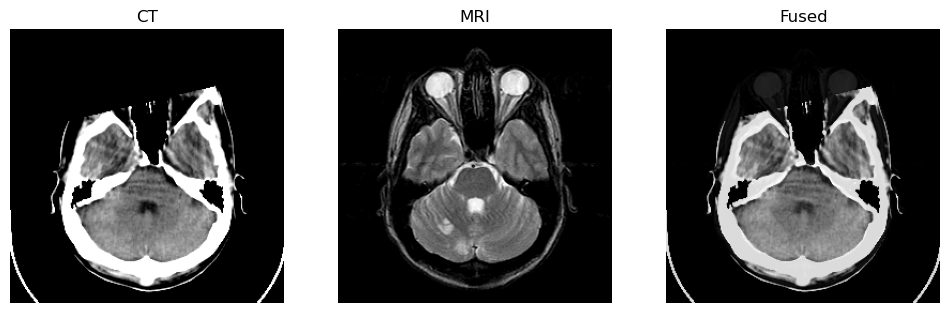

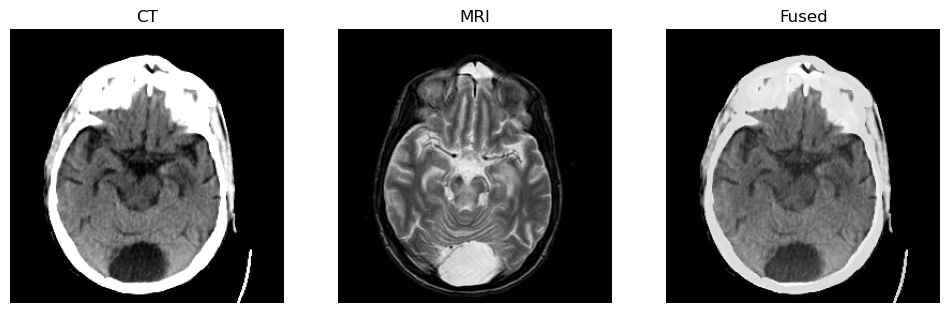

In [13]:
@torch.no_grad()
def show_triplet(ct, mr, fused):
    ct  = ct.detach().cpu().clamp(0,1)[0,0].numpy()
    mr  = mr.detach().cpu().clamp(0,1)[0,0].numpy()
    fus = fused.detach().cpu().clamp(0,1)[0,0].numpy()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(ct, cmap='gray'); axs[0].set_title('CT'); axs[0].axis('off')
    axs[1].imshow(mr, cmap='gray'); axs[1].set_title('MRI'); axs[1].axis('off')
    axs[2].imshow(fus, cmap='gray'); axs[2].set_title('Fused'); axs[2].axis('off')
    plt.show()

model.eval()
count = 0
with torch.no_grad():
    for ct, mr, _ in val_loader:
        ct = ct.to(device)
        mr = mr.to(device)
        fused = model(ct, mr)
        show_triplet(ct[:1], mr[:1], fused[:1])
        count += 1
        if count >= 2:
            break

## 7) Inference Helpers

In [14]:
@torch.no_grad()
def fuse_pair(model: WaveletFusionNet, ct_img: np.ndarray, mr_img: np.ndarray, resize: Tuple[int,int]=None, device=device) -> np.ndarray:
    ct = ct_img.copy().astype(np.float32)
    mr = mr_img.copy().astype(np.float32)
    if ct.ndim == 3: ct = cv2.cvtColor(ct, cv2.COLOR_BGR2GRAY)
    if mr.ndim == 3: mr = cv2.cvtColor(mr, cv2.COLOR_BGR2GRAY)
    if resize is not None:
        H,W = resize
        ct = cv2.resize(ct, (W,H), interpolation=cv2.INTER_AREA)
        mr = cv2.resize(mr, (W,H), interpolation=cv2.INTER_AREA)
    if ct.max() > 1.0: ct /= 255.0
    if mr.max() > 1.0: mr /= 255.0
    ct_t = torch.from_numpy(ct)[None,None].to(device)
    mr_t = torch.from_numpy(mr)[None,None].to(device)
    fused = model(ct_t, mr_t)
    fused = fused.clamp(0,1)[0,0].cpu().numpy()
    out = (fused*255.0).round().astype(np.uint8)
    return out

In [15]:
@torch.no_grad()
def fuse_folder(model_path: str, ct_dir: str, mr_dir: str, out_dir: str, resize: Tuple[int,int]=None):
    os.makedirs(out_dir, exist_ok=True)
    ckpt = torch.load(model_path, map_location=device)
    model = WaveletFusionNet().to(device)
    model.load_state_dict(ckpt['model'])
    model.eval()
    ds = PairedMedicalFusionDataset(ct_dir, mr_dir, resize=resize)
    for i in range(len(ds)):
        ct, mr, key = ds[i]
        ct_img = (ct.numpy()[0]*255).astype(np.uint8)
        mr_img = (mr.numpy()[0]*255).astype(np.uint8)
        fused = fuse_pair(model, ct_img, mr_img, resize=None, device=device)
        save_path = os.path.join(out_dir, key.replace(os.sep,'_') + '_fused.png')
        cv2.imwrite(save_path, fused)
    print('Saved fused images to', out_dir)

## 8) Tips / Extensions
- Add **Mutual Information (MI) loss** or **Entropy regularization** for information richness.
- Make weights **spatially varying**: replace scalars by a small CNN that predicts per-pixel alphas per band.
- Go multi-level DWT (J>1) if your images have large structures.
- Keep a medical expert in the loop: evaluate clinical relevance, not just numeric loss.